# Processing Time Influence on FWF

In this notebook, we dive deeper into the influence of the processing time onto the Flank Wear Failure (FWF) prediction.

This way, it is possible to understand if the dataset provides the necessary data to evaluate the drilling processes throught the evolution of time, or if it should only depend on other parameters.

Hypothesis: Since the Feature Importance did not show great value for "Processing Time", it is expected that this will not play a bigg role on FWF prediction. Additionally, it is know that processing time for drilling are usually consistent and constant for any parameters choices.

Software Lab 2025 Group 25

File made by: Eduardo Silva (03805057)
eduardo.silva@tum.de

Documentation made by: Eduardo Silva (03805057)

# 1) Import Libraries

Importing libraries that are necessary for evaluating the time processing feature importance. 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from pathlib import Path

# 2) Load Dataset and Create New "Important" Features

As it will be seen in the Degradation_Tool folder, after selecting feed (FF) we create a new variable for the torque by using the following equation:

$$ Torque = \frac{Power [kW]}{Spindle Speed [rpm]} = \frac{Power [W]}{Spindle Speed [rad/s]} * \frac{1000*60}{2 * \pi} \simeq 9550 * \frac{Power [W]}{Spindle Speed [rad/s]}$$

, and:

$$ Tf = \frac{Torque}{Feed \ \ [mm/rev]}$$

This new variable named "Tf" encompasses the information of the most important feature (Feed or Feed rate) and it integrates information from the torque. On the Degradation_Tool folder, it is possible to see that this variable creates a good distinction between failure, wear and good quality of the FWF prediction.

For now, we focus on attempting to show once that the feature "Processing Time" is still irrelevant for the case where we consider a primary variable from the dataset (Cutting Speed) and a secondary variable created "Tf".

In [4]:
# load dataset
# Current working directory (notebook location)
BASE_DIR = Path.cwd()

# get the correct path for the dataset file (if locations are changed then this also need to be changed)
file_path = BASE_DIR.parent / "XAI_Drilling_Dataset.csv"
df = pd.read_csv(file_path)
print(df.head())

# create variables for Torque and for Torque / Feed
df['Torque'] = (9550 * df['Power Pc [kW]']) / df['Spindle speed n [1/min]']
df['Tf'] = df['Torque'] / df['Feed f [mm/rev]']

# store the hardness of each material provided in the dataset's paper
material_hardness = {'N': 70, 'P': 180, 'K': 160}

# create a new colum with a mapping from material's letter to material's hardness
df['Hardness'] = df['Material'].map(material_hardness)
df.head()

   ID  Cutting speed vc [m/min]  Spindle speed n [1/min]  Feed f [mm/rev]  \
0   1                     29.92                      794            0.218   
1   2                     29.85                      792            0.241   
2   3                     22.85                      606            0.183   
3   4                     29.60                      785            0.236   
4   5                     17.43                      462            0.246   

   Feed rate vf [mm/min]  Power Pc [kW]  Cooling [%] Material Drill Bit Type  \
0                    173         194.87           75        N              W   
1                    191         214.71           75        N              W   
2                    111          95.68           50        P              N   
3                    237         206.93           75        N              W   
4                    114          74.85           50        K              H   

   Process Time [sec]  Main Failure  BEF  CCF  FWF  WDF 

,ID,Cutting speed vc [m/min],Spindle speed n [1/min],Feed f [mm/rev],Feed rate vf [mm/min],Power Pc [kW],Cooling [%],Material,Drill Bit Type,Process Time [sec],Main Failure,BEF,CCF,FWF,WDF,Torque,Tf,Hardness
0,1,29.92,794,0.218,173,194.87,75,N,W,19.26,0,0,0,0,0,2343.839421,10751.556975,70
1,2,29.85,792,0.241,191,214.71,75,N,W,19.55,0,0,0,0,0,2588.990530,10742.699296,70
2,3,22.85,606,0.183,111,95.68,50,P,N,36.16,0,0,0,0,0,1507.828383,8239.499360,180
3,4,29.60,785,0.236,237,206.93,75,N,W,21.22,1,0,0,1,0,2517.428662,10667.070603,70
4,5,17.43,462,0.246,114,74.85,50,K,H,33.56,0,0,0,0,0,1547.224026,6289.528561,160


# 3) Apply the criteria for Flank Wear Failure (FWF) by using the values of cutting speed (VC) and the new variables created Tf (Torque/Feed)

Now by using these feature's values, we can classify for which regions of values we get the FWF criteira. For this, by reading literature it is found that the failure of a drilling process is caracterized by the following curve:

![Tool Wear Evolution](Failure_Graph.png)

By evaluating the image above, we select the different regions:

* Zone 0 (Safe): Corresponds to the section 1, where it is assumed that minimal or no wear occurs in the tool.
* Zone 1 (Warning): Corresponds to sections 2, 3, 4. Here, the wear is approximetly linear, and for that reason it is consider that other types of failure occur in the tool, but not FWF (Flank Wear Failure).
* Zone 2 (Failure): Corresponds to section 5, where wear increases non-linearly. For this scenario we assum that there is FWF.

In [5]:
# choose minimums of cutting speed and Torque/feed as limits for failure
df_vc = df[df['FWF'] == 1]['Cutting speed vc [m/min]'].min()
df_tf = df[df['FWF'] == 1]['Tf'].min()

# function to classify failure FWF (leading to degradation of drilling)
# return 0 -> no degradation
# return 1 -> degradation in drilling
# return 2 -> failure of drilling flank
def classify_zone(row):
    #if values for variables are lower that the minimums for FWF = 1
    if (row['Cutting speed vc [m/min]'] <= df_vc) or (row['Tf'] <= df_tf):
        return 2
    # if FWF = 1, then clearly there is FWF Failure
    elif row['FWF'] == 1:
        return 2
    # if any other type of failure occurs but not FWF
    elif row['FWF'] == 0 and row['Main Failure'] == 1:
        return 1
    # no failures
    else:
        return 0

# create new variable to characterize failures
df['Zone_3Class'] = df.apply(classify_zone, axis=1)

# 4) Plotting Results

After applying the classification of regions, it is possible to acquire the values of the feature "Processing Time" for each scenario.

With this, it is shown below the graph between the relation of "Processing Time" and the caracterization of the different classes (0, 1, 2) for the Flank Wear Failure (FWF).

/tmp/ipykernel_2350/2108253659.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


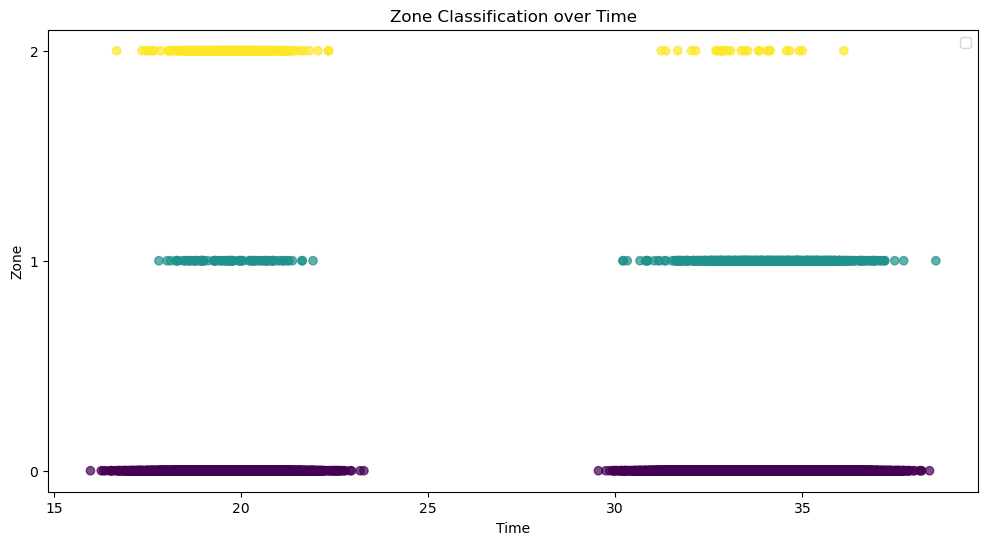

In [6]:
import matplotlib.pyplot as plt

# plot results
plt.figure(figsize=(12,6))
plt.scatter(df["Process Time [sec]"], df["Zone_3Class"], c=df["Zone_3Class"], cmap="viridis", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Zone")
plt.title("Zone Classification over Time")
plt.yticks([0,1,2])
plt.legend()
plt.show()

# Analysis Notes

As seen above, the different classification of zones (0, 1, 2) are spaned through very similar intervals of time of drilling. 
This (together with the results from feature importance) show once again that the processing time of the drilling experiment are not relevant for the flank wear degradation. 

Rather, given that all processes usually take between 15 and 30 seconds, it has been already shown that it is more important to consider which values are used for Feed rate and for Cutting speed for the drilling process to make an accurate prediction of FWF.